<a href="https://colab.research.google.com/github/abhisheksuran/Atari_DQN/blob/master/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# sh -c 'pip install tensorflow tensorflow-metal tqdm gymnasium[classic-control] tensorflow_probability ipywidgets matplotlib pyvirtualdisplay'
import numpy as np
import tensorflow as tf 
import gymnasium as gym
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

print(tf.__version__)

2.15.0


https://www.gymlibrary.dev/environments/classic_control/cart_pole/

https://en.wikipedia.org/wiki/Proximal_Policy_Optimization

https://www.gymlibrary.dev/content/environment_creation/

In [2]:
env= gym.make("CartPole-v1", render_mode='rgb_array')
low = env.observation_space.low
high = env.observation_space.high

In [3]:
class critic(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(128,activation='relu')
    self.v = tf.keras.layers.Dense(1, activation = None)

  def call(self, input_data):
    x = self.d1(input_data)
    v = self.v(x)
    return v
    

class actor(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(128,activation='relu')
    self.a = tf.keras.layers.Dense(2,activation='softmax')

  def call(self, input_data):
    x = self.d1(input_data)
    a = self.a(x)
    return a

In [4]:
class agent():
    def __init__(self, gamma = 0.99):
        self.gamma = gamma
        # self.a_opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
        # self.c_opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
        self.a_opt = tf.keras.optimizers.legacy.Adam(learning_rate=7e-3)
        self.c_opt = tf.keras.optimizers.legacy.Adam(learning_rate=7e-3)
        self.actor = actor()
        self.critic = critic()
        self.clip_pram = 0.2

          
    def act(self,state):
        prob = self.actor(np.array([state]))
        prob = prob.numpy()
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])
  


    def actor_loss(self, probs, actions, adv, old_probs, closs):
        
        probability = probs      
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability,tf.math.log(probability))))
        #print(probability)
        #print(entropy)
        sur1 = []
        sur2 = []
        
        for pb, t, op,a  in zip(probability, adv, old_probs, actions):
                        t =  tf.constant(t)
                        #op =  tf.constant(op)
                        #print(f"t{t}")
                        #ratio = tf.math.exp(tf.math.log(pb + 1e-10) - tf.math.log(op + 1e-10))
                        ratio = tf.math.divide(pb[a],op[a])
                        #print(f"ratio{ratio}")
                        s1 = tf.math.multiply(ratio,t)
                        #print(f"s1{s1}")
                        s2 =  tf.math.multiply(tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram),t)
                        #print(f"s2{s2}")
                        sur1.append(s1)
                        sur2.append(s2)

        sr1 = tf.stack(sur1)
        sr2 = tf.stack(sur2)
        
        #closs = tf.reduce_mean(tf.math.square(td))
        loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) - closs + 0.001 * entropy)
        #print(loss)
        return loss

    def learn(self, states, actions,  adv , old_probs, discnt_rewards):
        discnt_rewards = tf.reshape(discnt_rewards, (len(discnt_rewards),))
        adv = tf.reshape(adv, (len(adv),))

        old_p = old_probs

        old_p = tf.reshape(old_p, (len(old_p),2))
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            p = self.actor(states, training=True)
            v =  self.critic(states,training=True)
            v = tf.reshape(v, (len(v),))
            td = tf.math.subtract(discnt_rewards, v)
            c_loss = 0.5 * kls.mean_squared_error(discnt_rewards, v)
            a_loss = self.actor_loss(p, actions, adv, old_probs, c_loss)
            
        grads1 = tape1.gradient(a_loss, self.actor.trainable_variables)
        grads2 = tape2.gradient(c_loss, self.critic.trainable_variables)
        self.a_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
        self.c_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
        return a_loss, c_loss

In [5]:
def test_reward(env):
  total_reward = 0
  state, _ = env.reset()
  done = False
  truncated = False
  while not done and not truncated:
    action = np.argmax(agentoo7.actor(np.array([state])).numpy())
    next_state, reward, done, truncated, _ = env.step(action)
    state = next_state
    total_reward += reward

  return total_reward

In [10]:
from tqdm.notebook import tqdm
# Use this to disable GPU
tf.config.set_visible_devices([], 'GPU')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def preprocess1(states, actions, rewards, done, values, gamma):
    g = 0
    lmbda = 0.95
    returns = []
    for i in reversed(range(len(rewards))):
       delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
       g = delta + gamma * lmbda * dones[i] * g
       returns.append(g + values[i])

    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions, dtype=np.int32)
    returns = np.array(returns, dtype=np.float32)
    return states, actions, returns, adv    


tf.random.set_seed(336699)
agentoo7 = agent()
steps = 5000
ep_reward = []
total_avgr = []
target = False 
best_reward = 0
avg_rewards_list = []

_tqdm = tqdm(range(steps))
for s in _tqdm:
  if target == True:
          break
  
  done = False
  state, _ = env.reset()
  all_aloss = []
  all_closs = []
  rewards = []
  states = []
  actions = []
  probs = []
  dones = []
  values = []

  for e in range(128):
    action = agentoo7.act(state)
    value = agentoo7.critic(np.array([state])).numpy()
    next_state, reward, done, _, _ = env.step(action)
    dones.append(1-done)
    rewards.append(reward)
    states.append(state)
    #actions.append(tf.one_hot(action, 2, dtype=tf.int32).numpy().tolist())
    actions.append(action)
    prob = agentoo7.actor(np.array([state]))
    probs.append(prob[0])
    values.append(value[0][0])
    state = next_state
    if done:
      env.reset()
  
  value = agentoo7.critic(np.array([state])).numpy()
  values.append(value[0][0])
  np.reshape(probs, (len(probs),2))
  probs = np.stack(probs, axis=0)

  states, actions,returns, adv  = preprocess1(states, actions, rewards, dones, values, 1)

  for epocs in range(10):
      al,cl = agentoo7.learn(states, actions, adv, probs, returns)
      # print(f"al{al}") 
      # print(f"cl{cl}")   

  avg_reward = np.mean([test_reward(env) for _ in range(5)])

  avg_rewards_list.append(avg_reward)
  if avg_reward > best_reward:
        agentoo7.actor.save('output/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        agentoo7.critic.save('output/model_critic_{}_{}'.format(s, avg_reward), save_format="tf")
        best_reward = avg_reward
  _tqdm.set_postfix(Result="Average: {}, best: {}".format(avg_reward, best_reward))
  if best_reward == 500:
        target = True
  env.reset()

env.close()
    
  

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
from IPython import display

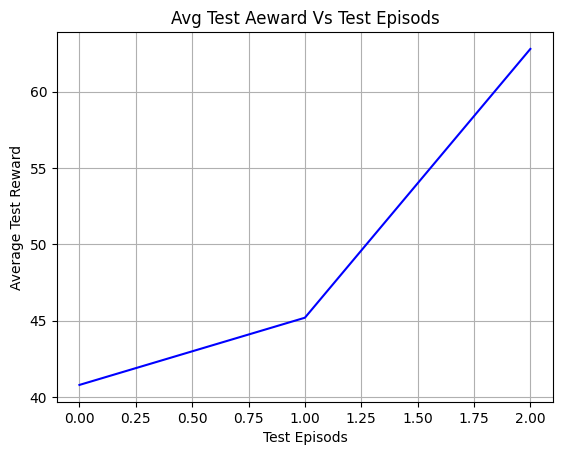

In [8]:
ep = [i  for i in range(len(avg_rewards_list))]
plt.plot( range(len(avg_rewards_list)),avg_rewards_list,'b')
plt.title("Avg Test Aeward Vs Test Episods")
plt.xlabel("Test Episods")
plt.ylabel("Average Test Reward")
plt.grid(True)
plt.show()

KeyboardInterrupt: 

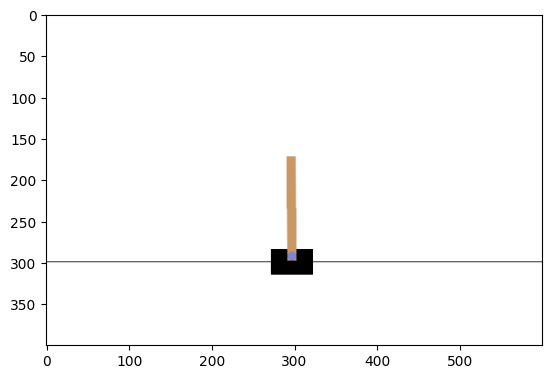

In [9]:
state, _ = env.reset()
done = False
truncated = False
while not done and not truncated:
    action = np.argmax(agentoo7.actor(np.array([state])).numpy())
    next_state, reward, done, truncated, _ = env.step(action)
    state = next_state
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)